# 신용카드 사기거래 탐지
<hr>

### Kaggle의 [Creadit Card Transaction Fraud Dataset](https://www.kaggle.com/datasets/kartik2112/fraud-detection)을 이용한 신용카드 사기거래 데이터 분석 및 분류 예측

### 목차
1. 데이터셋 불러오기
2. 탐색적 데이터 분석 (EDA)
3. 예측 모델을 위한 Feature 선택
4. 데이터 불균형 문제 해결
5. 모델 생성 및 분류 예측
6. 결과

<hr>

# 
# 1. 데이터셋 불러오기

In [1]:
import utils
import models
import train
import datasets
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train, y_train = datasets.load_train_dataset()
X_test, y_test = datasets.load_test_dataset()

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   cc_num                 1296675 non-null  int64         
 2   merchant               1296675 non-null  object        
 3   category               1296675 non-null  object        
 4   amt                    1296675 non-null  float64       
 5   first                  1296675 non-null  object        
 6   last                   1296675 non-null  object        
 7   gender                 1296675 non-null  object        
 8   street                 1296675 non-null  object        
 9   city                   1296675 non-null  object        
 10  state                  1296675 non-null  object        
 11  zip                    1296675 non-null  int64         
 12  lat                    12966

<hr>

# 
# 2.  탐색적 데이터 분석 (EDA)

### 
### 상관관계분석

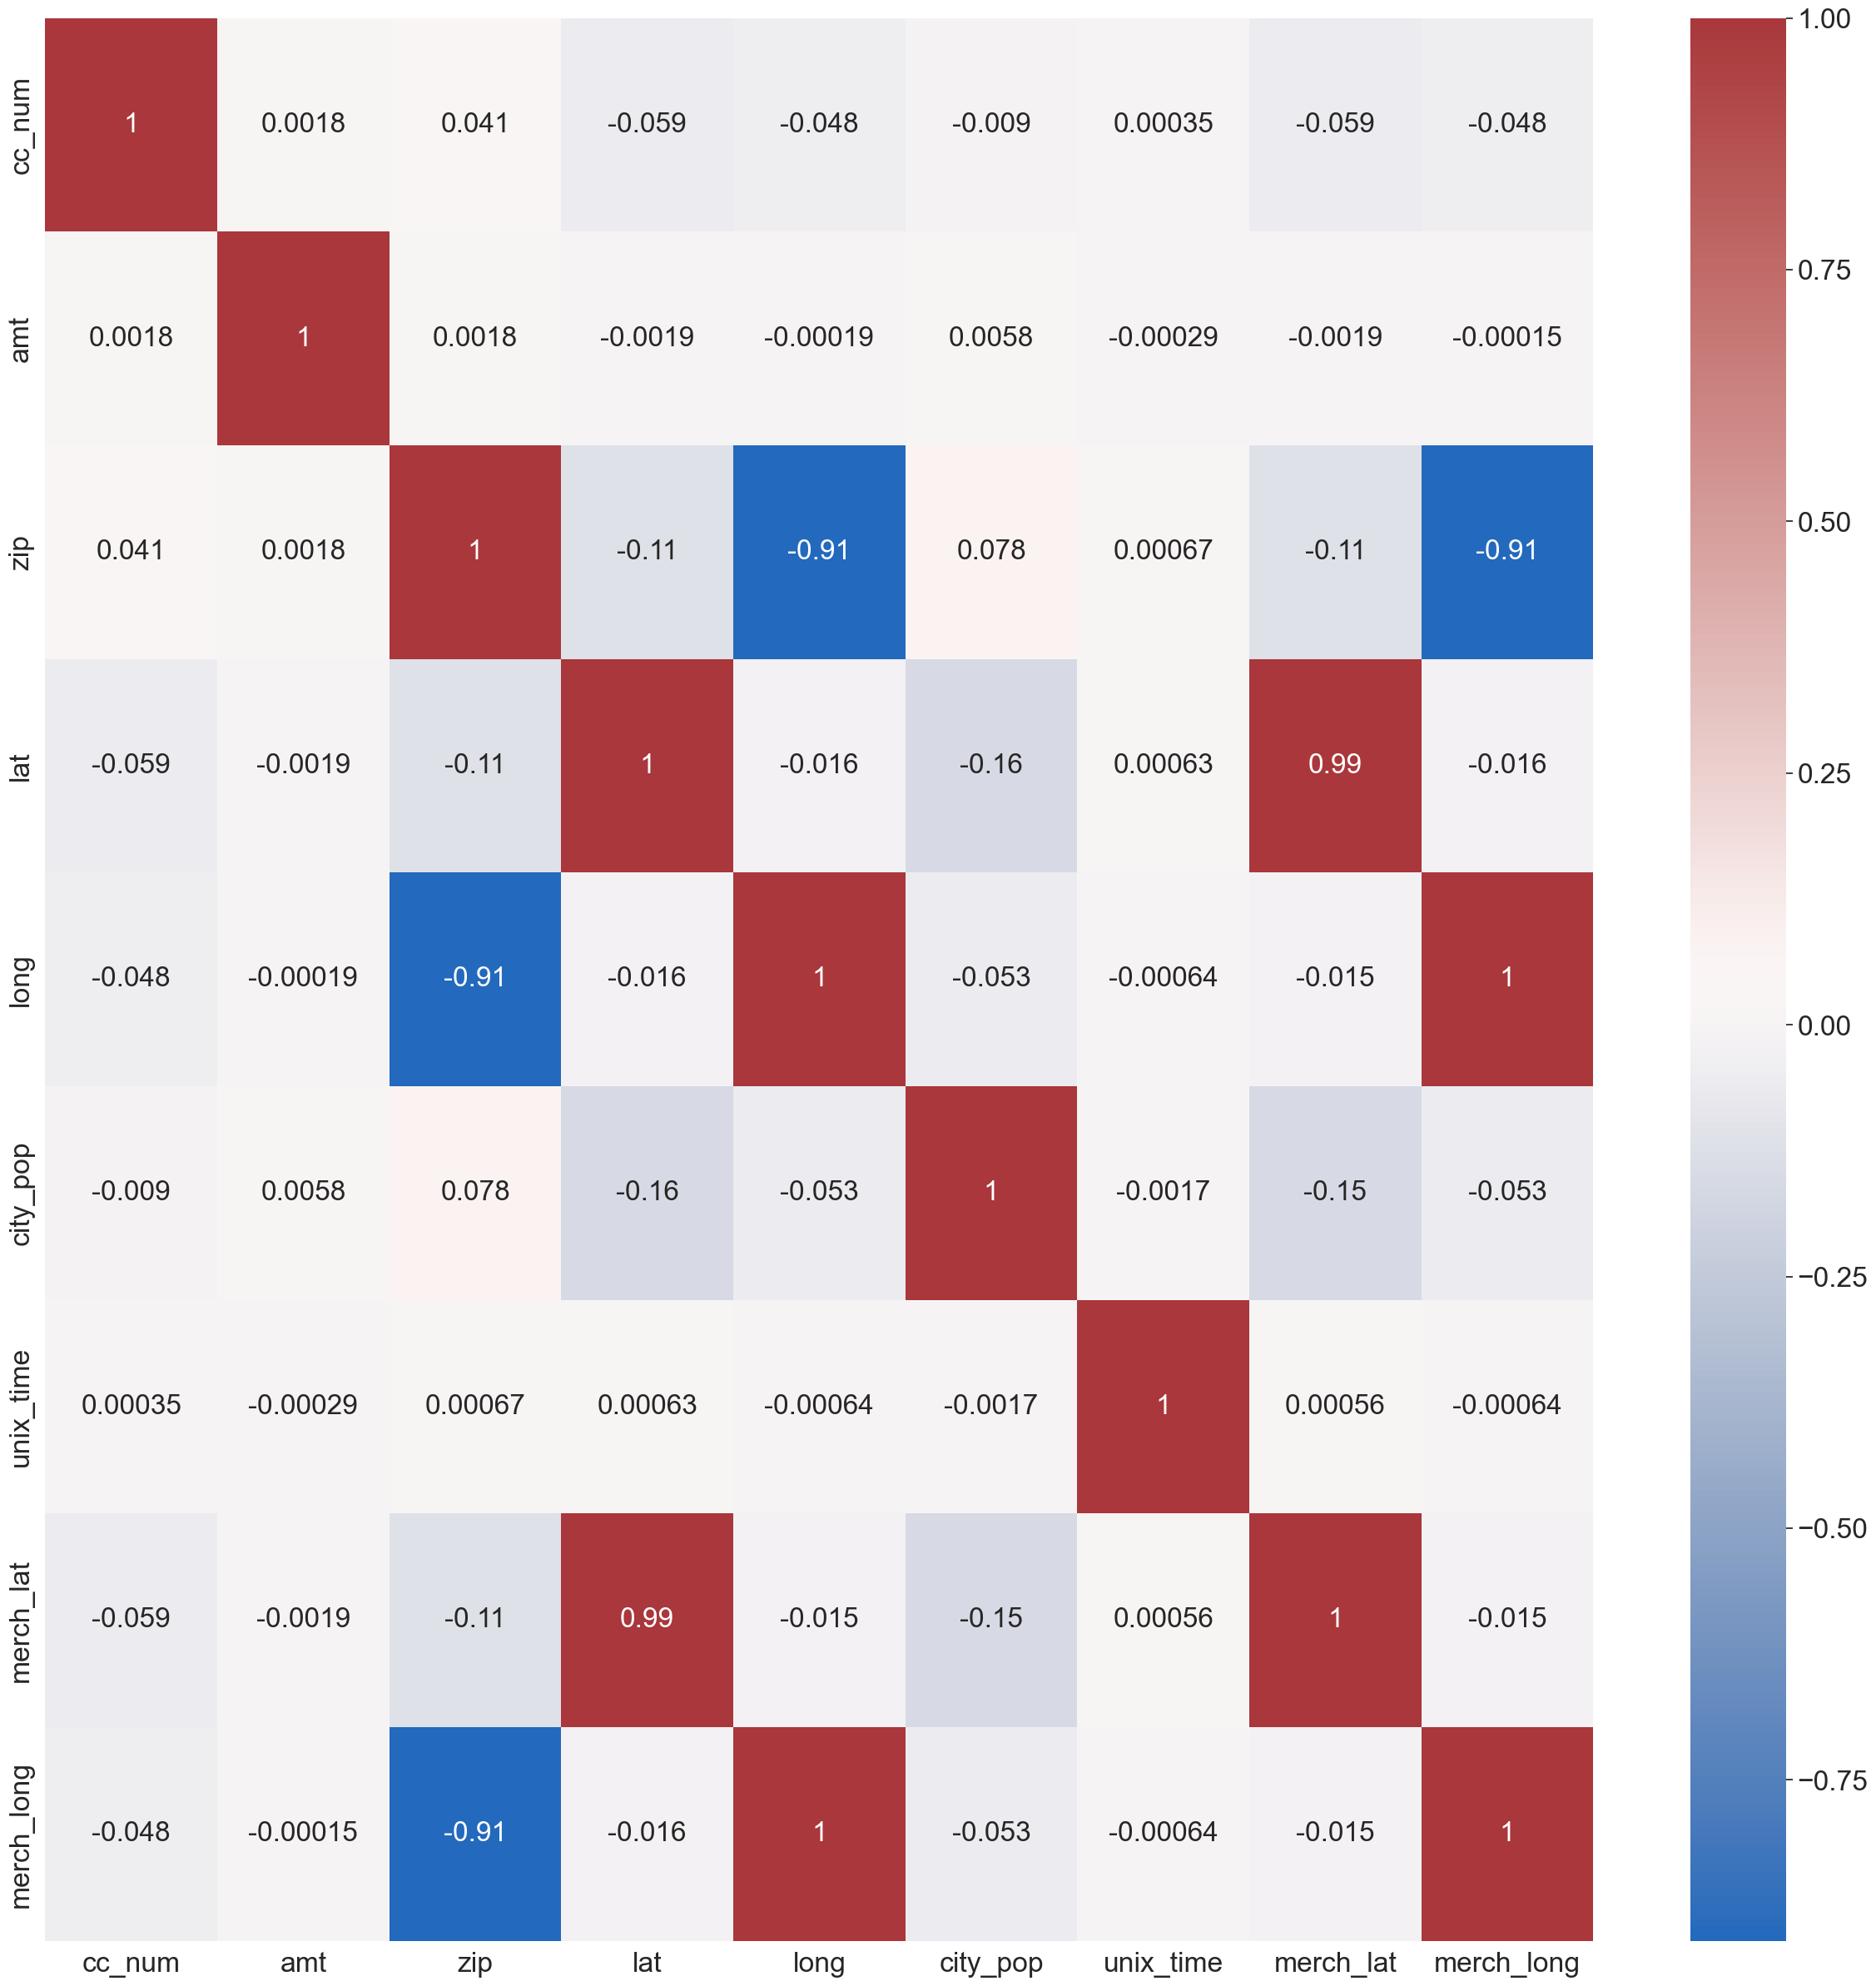

In [4]:
utils.draw_heatmap(X_train)

### 
### 피쳐 추가, 인코딩 및 이름 변경

In [5]:
# 칼럼 이름 변경
X_train.rename(columns={"trans_date_trans_time": "trans_time"}, inplace=True)
X_test.rename(columns={"trans_date_trans_time": "trans_time"}, inplace=True)
X_train.rename(columns={"category": "merch_cat"}, inplace=True)
X_test.rename(columns={"category": "merch_cat"}, inplace=True)
# 레이블 인코딩
utils.convert_category_to_num_label(X_train, 'gender')
utils.convert_category_to_num_label(X_test, 'gender')
# 시간 칼럼 추가
X_train['hour'] = X_train['trans_time'].dt.hour
X_test['hour'] = X_test['trans_time'].dt.hour
# 요일 칼럼 추가
X_train['day'] = X_train['trans_time'].dt.weekday
X_test['day'] = X_test['trans_time'].dt.weekday
# 월별 칼럼 추가
X_train['month'] = X_train['trans_time'].dt.month
X_test['month'] = X_test['trans_time'].dt.month
# 나이 칼럼 추가
X_train['age'] = 2020 - X_train['dob'].dt.year
X_test['age'] = 2020 - X_test['dob'].dt.year

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 25 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   trans_time  1296675 non-null  datetime64[ns]
 1   cc_num      1296675 non-null  int64         
 2   merchant    1296675 non-null  object        
 3   merch_cat   1296675 non-null  object        
 4   amt         1296675 non-null  float64       
 5   first       1296675 non-null  object        
 6   last        1296675 non-null  object        
 7   gender      1296675 non-null  int64         
 8   street      1296675 non-null  object        
 9   city        1296675 non-null  object        
 10  state       1296675 non-null  object        
 11  zip         1296675 non-null  int64         
 12  lat         1296675 non-null  float64       
 13  long        1296675 non-null  float64       
 14  city_pop    1296675 non-null  int64         
 15  job         1296675 non-null  ob

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 거래금액 분포

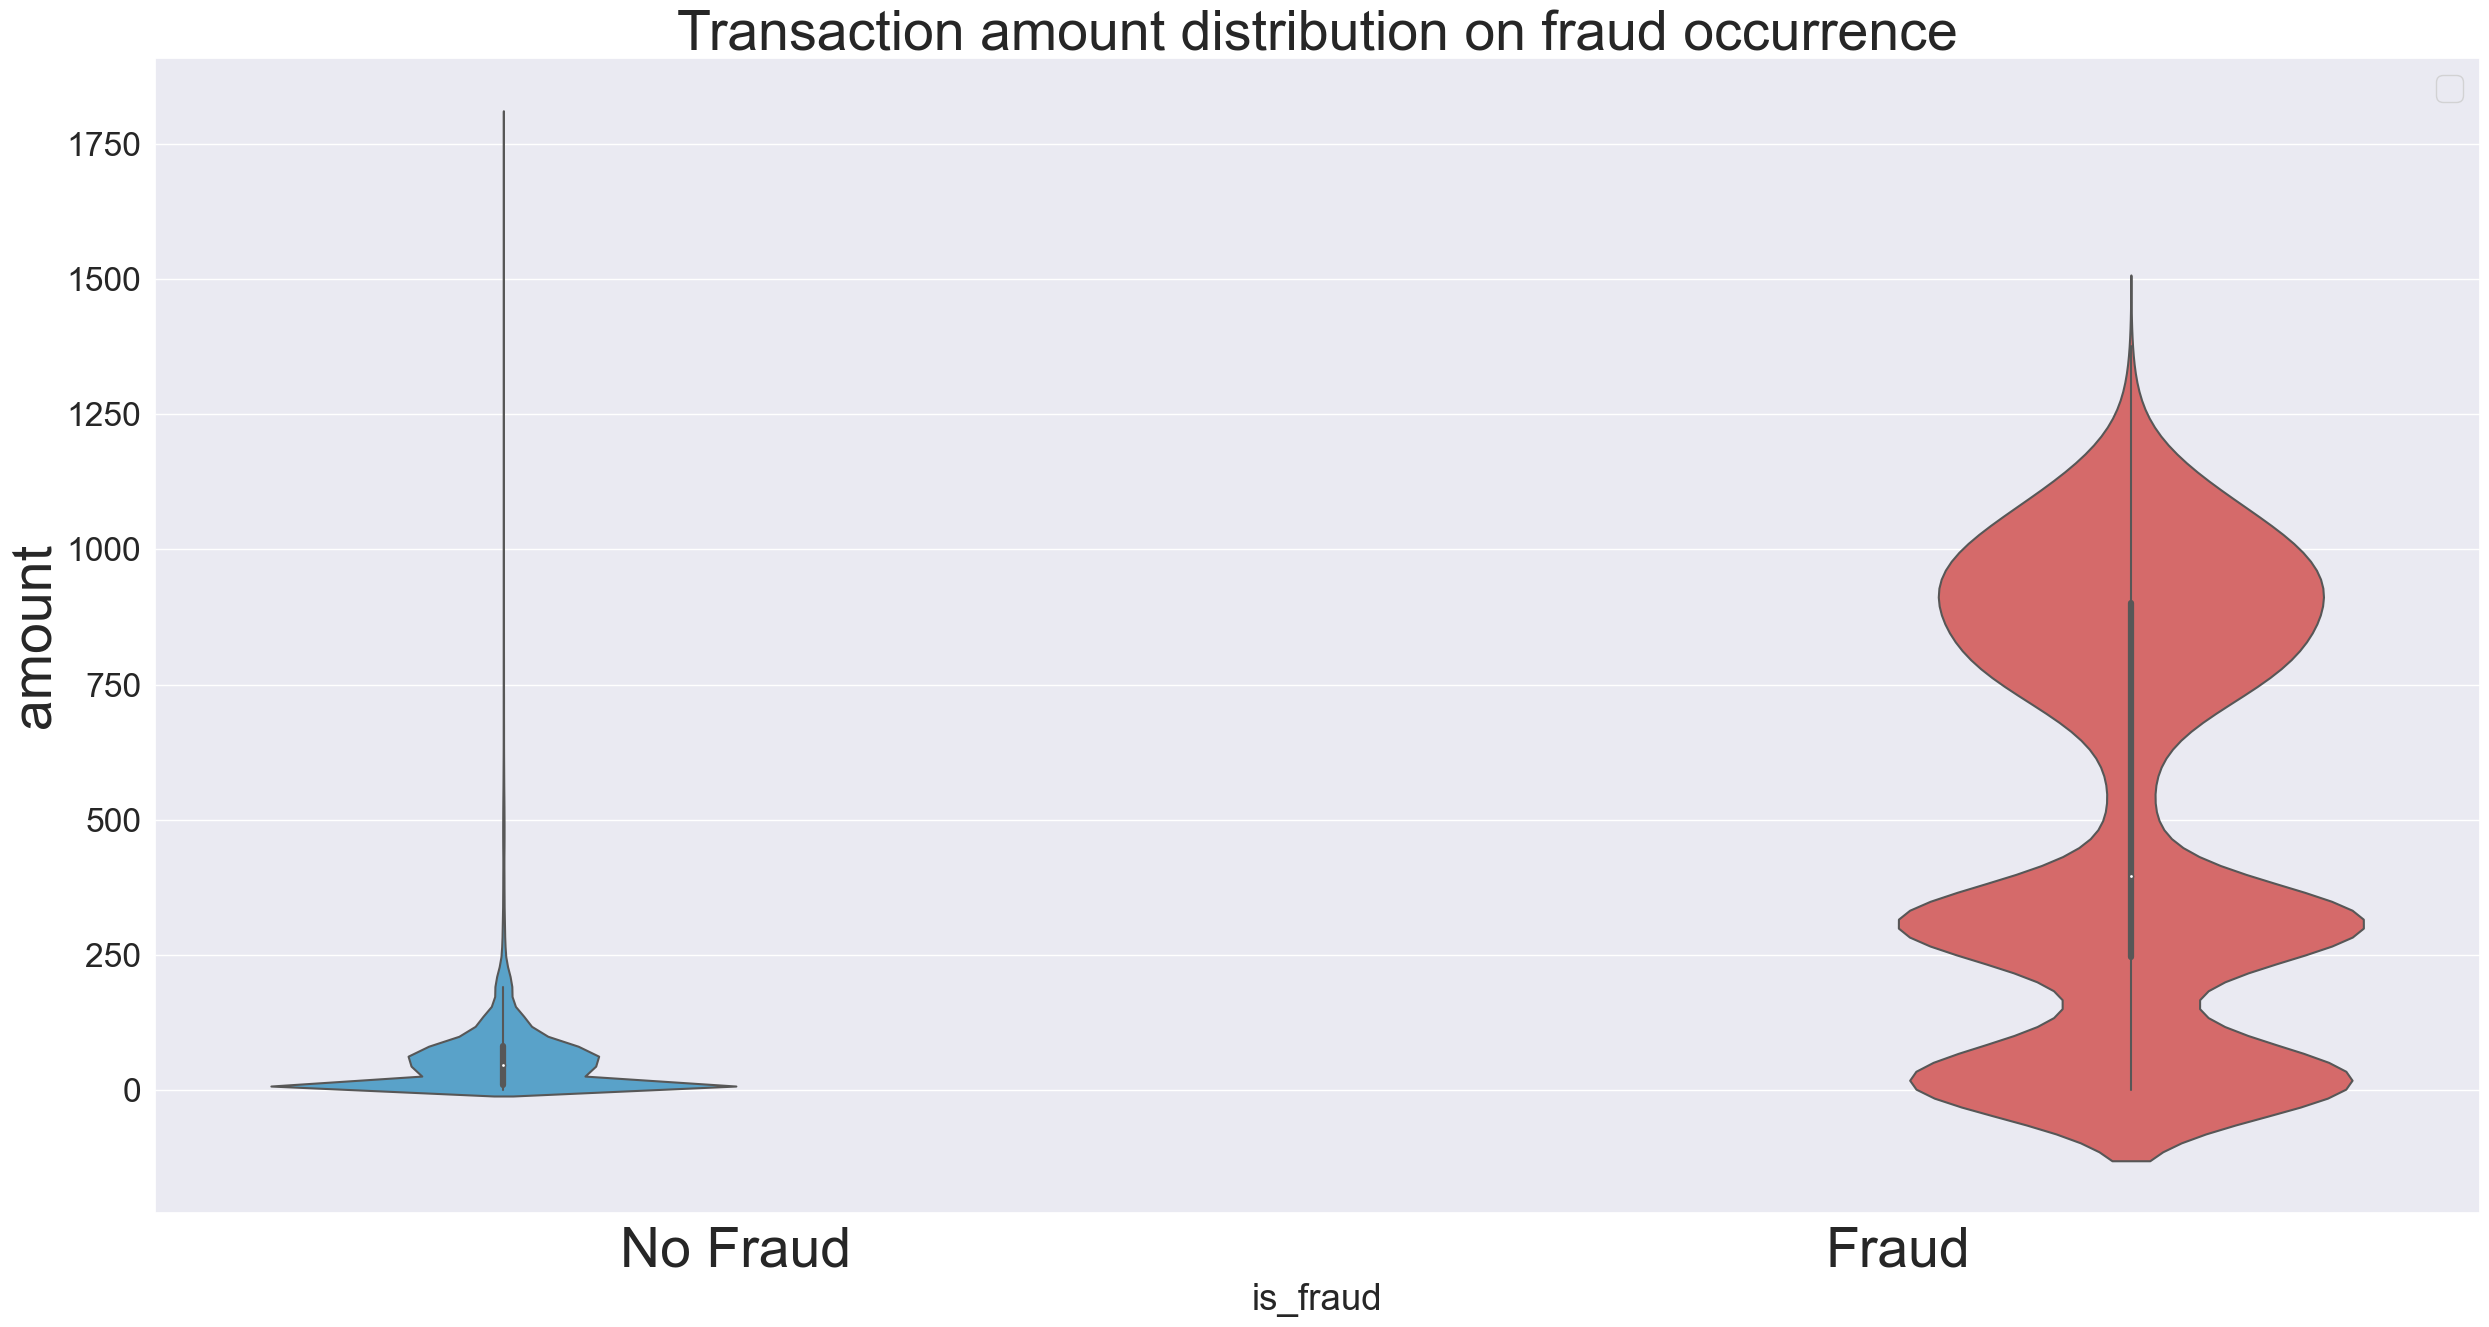

In [7]:
plt.figure(figsize=(30,15))

amt_fraud_df = pd.concat([X_train['amt'], y_train], axis=1)
ax = sns.violinplot(data=amt_fraud_df.loc[amt_fraud_df['amt']<1800,:], x='is_fraud', y='amt', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Transaction amount distribution on fraud occurrence', 40),  
                      ylab=('amount',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 연령 분포

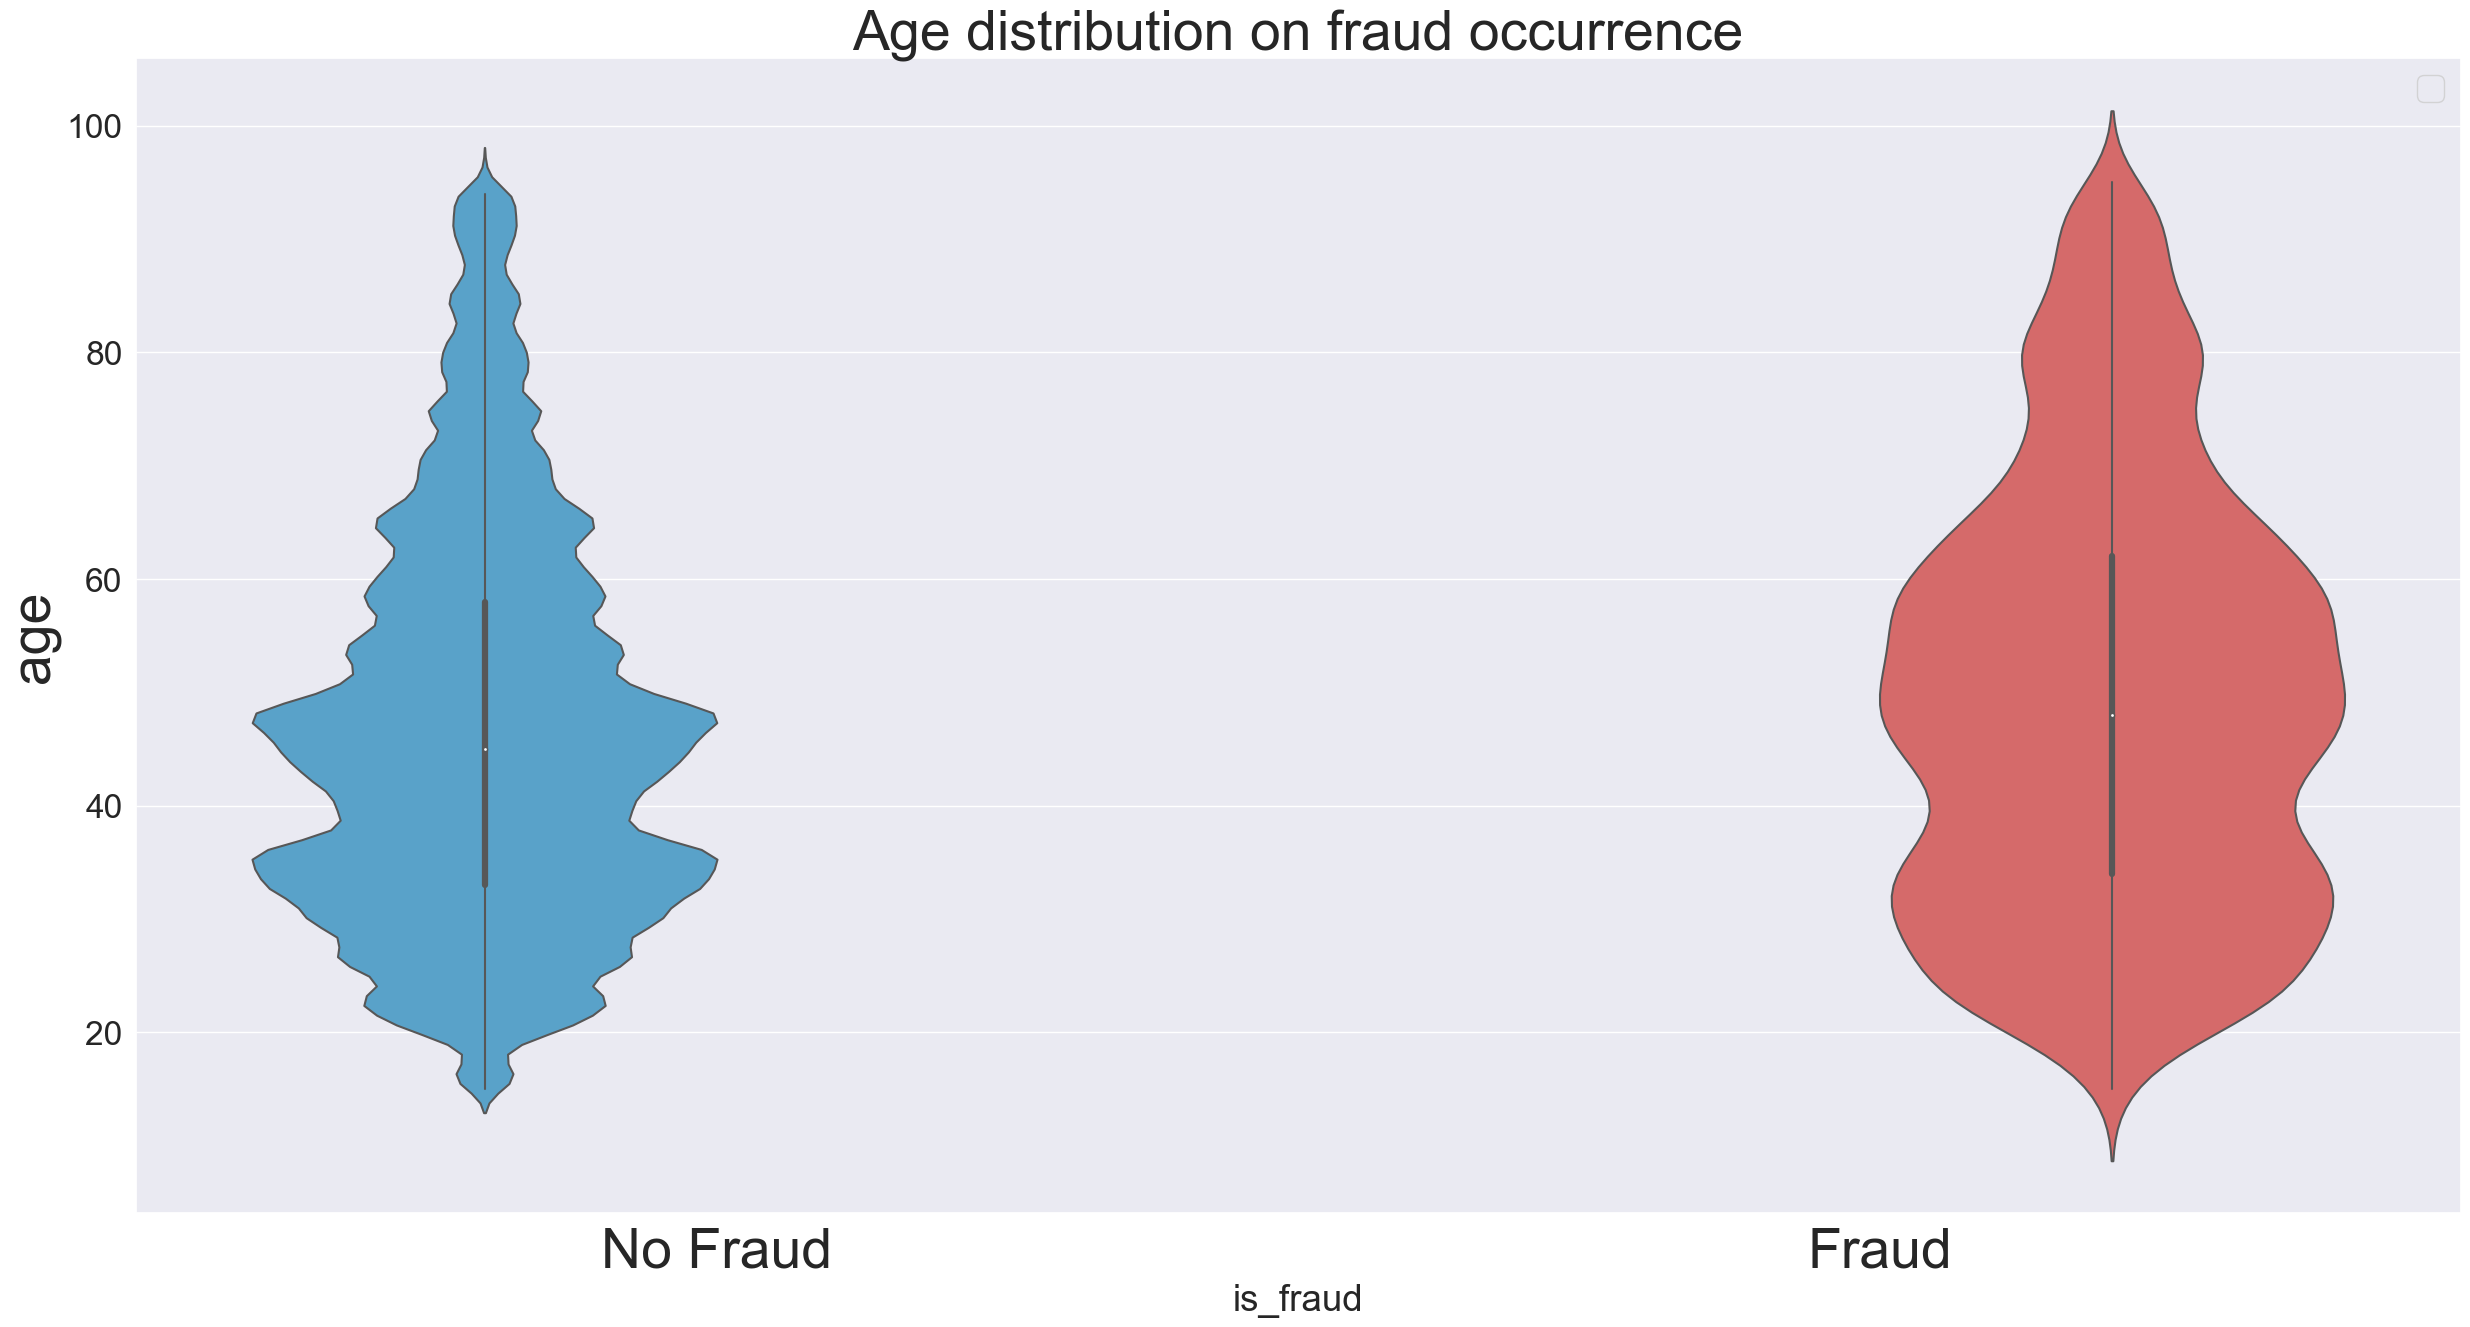

In [8]:
plt.figure(figsize=(30,15))

age_fraud_df = pd.concat([X_train['age'], y_train], axis=1)
ax = sns.violinplot(data=age_fraud_df, x='is_fraud', y='age', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Age distribution on fraud occurrence', 40),  
                      ylab=('age',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 연령대별 신용카드 사기거래(오른쪽)와 일반거래(왼쪽) 추세 분석

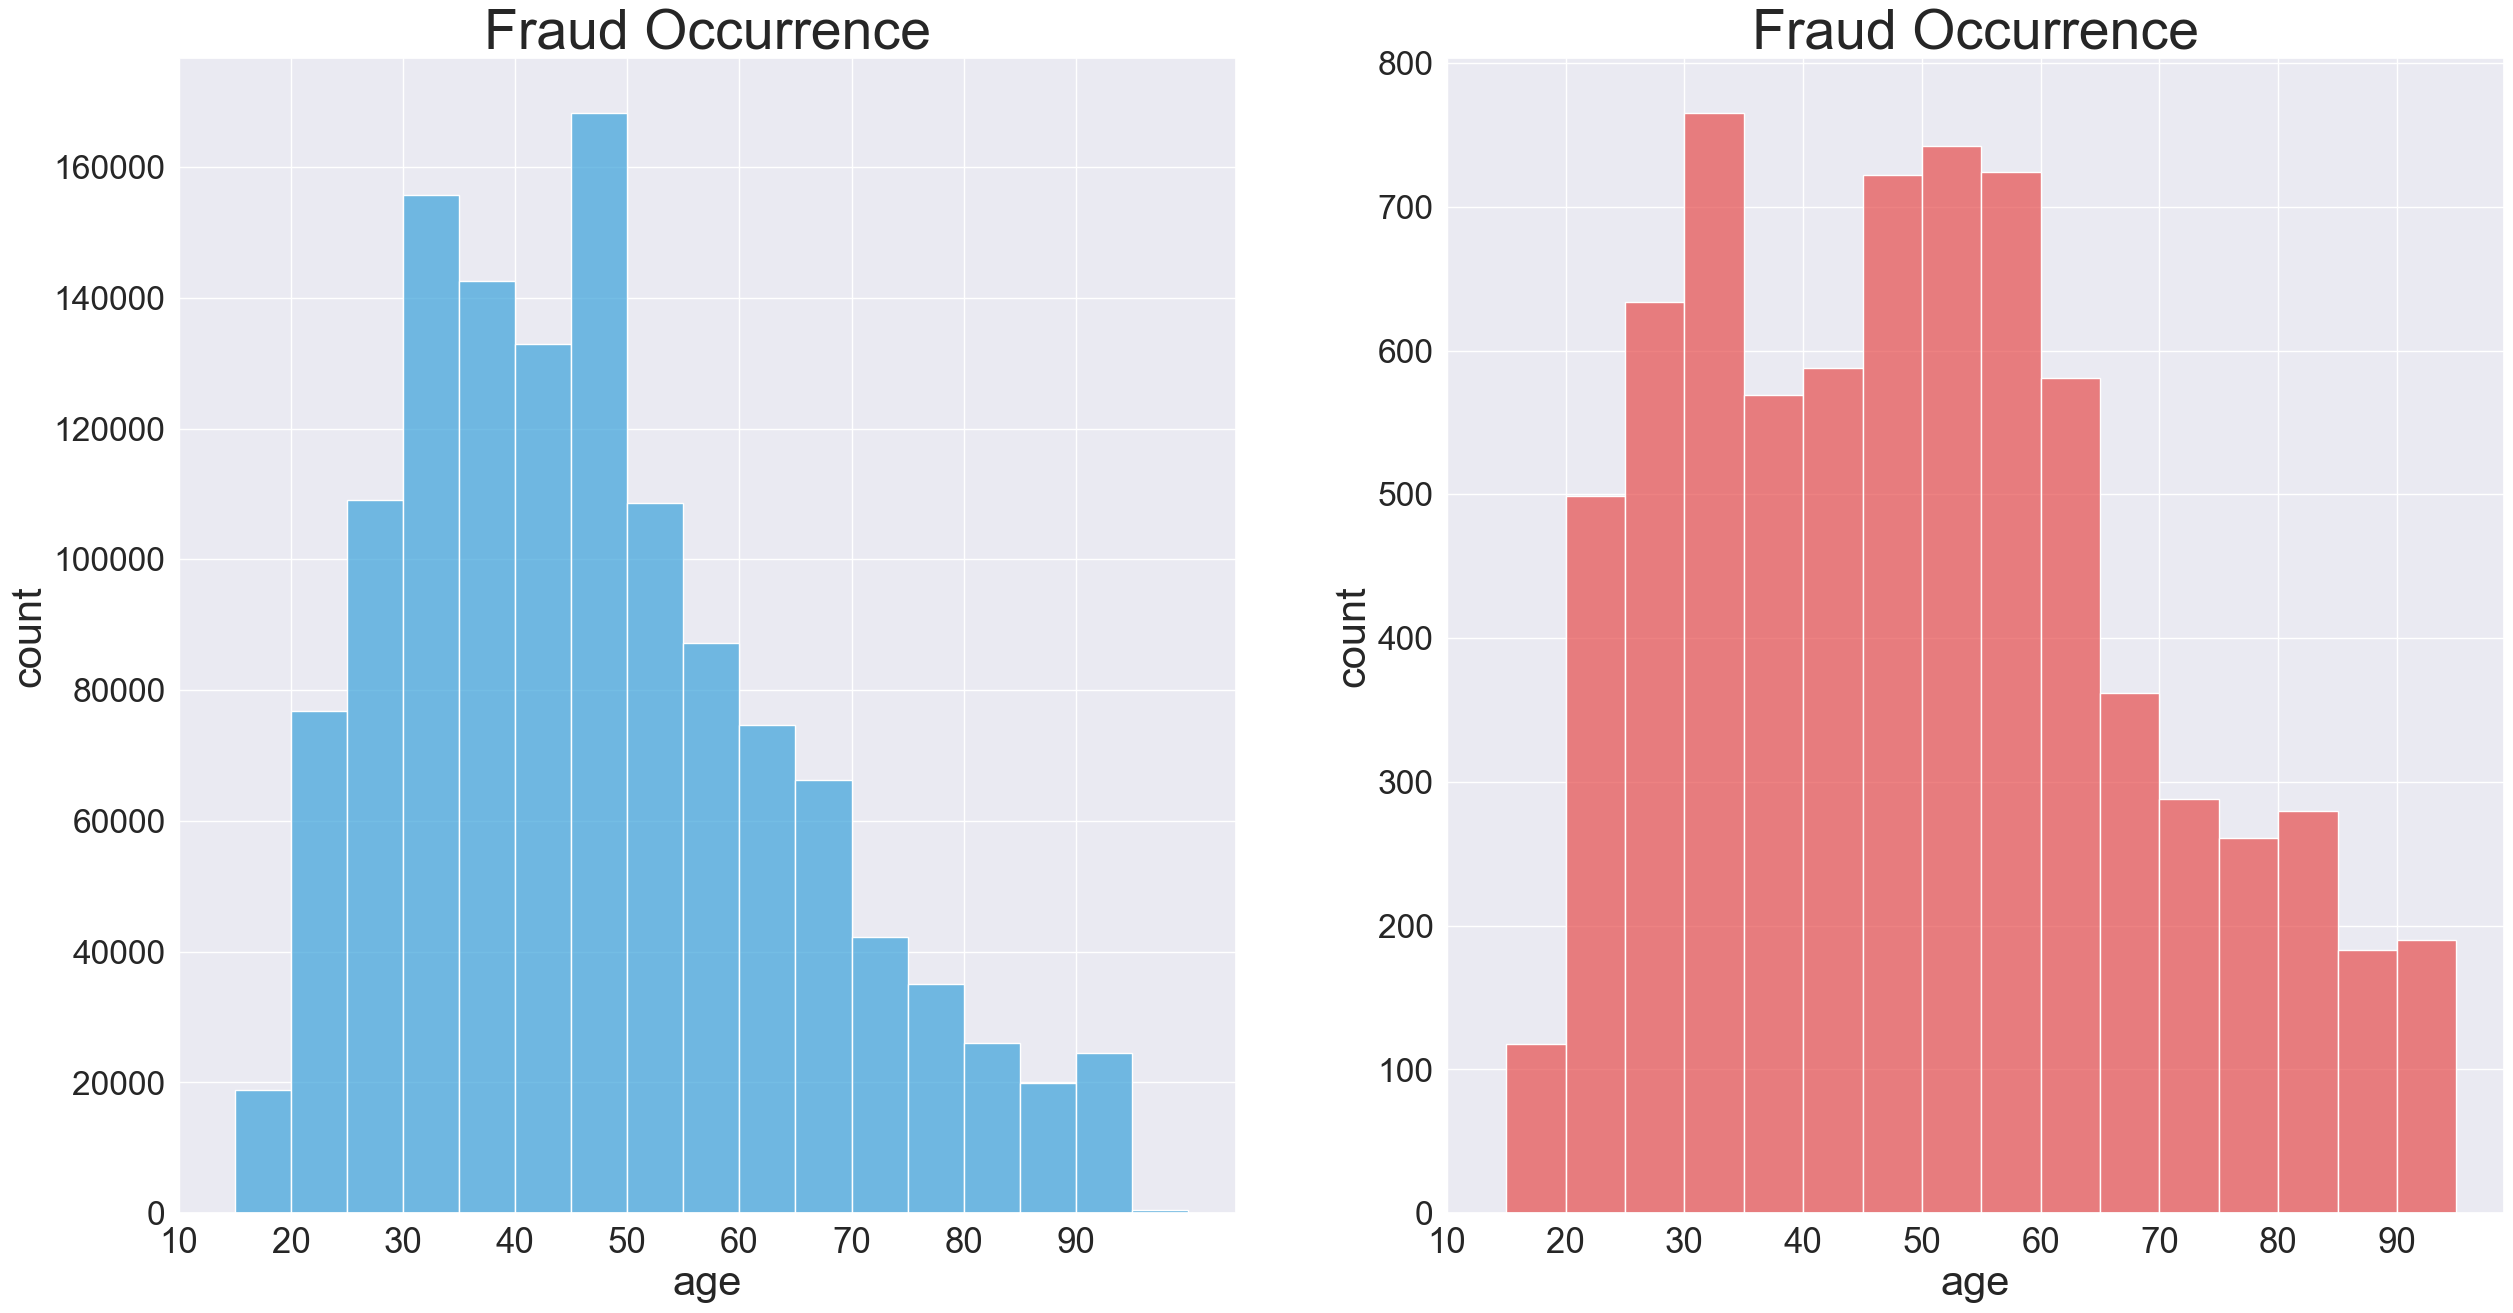

In [9]:
plt.figure(figsize=(30,15))

plt.subplot(1, 2, 1)
ax1 = sns.histplot(x='age',data=X_train.loc[y_train==0,:], common_norm=False, stat='count', multiple='stack', binwidth=5, color='#46A7DC')
ax1 = utils.set_plot_labels(ax1, ('Fraud Occurrence', 40), ('age',30), ('count',30))
plt.xticks(range(10, 100, 10), size=25)
plt.subplot(1, 2, 2)
ax2 = sns.histplot(x='age',data=X_train.loc[y_train==1,:], common_norm=False, stat='count', multiple='stack', binwidth=5, color="#E75858")
ax2 = utils.set_plot_labels(ax2, ('Fraud Occurrence', 40), ('age',30), ('count',30))
plt.xticks(range(10, 100, 10), size=25)

plt.show()

### 
### 일반거래(왼쪽)와 사기거래(오른쪽)의 발생 시간 분포

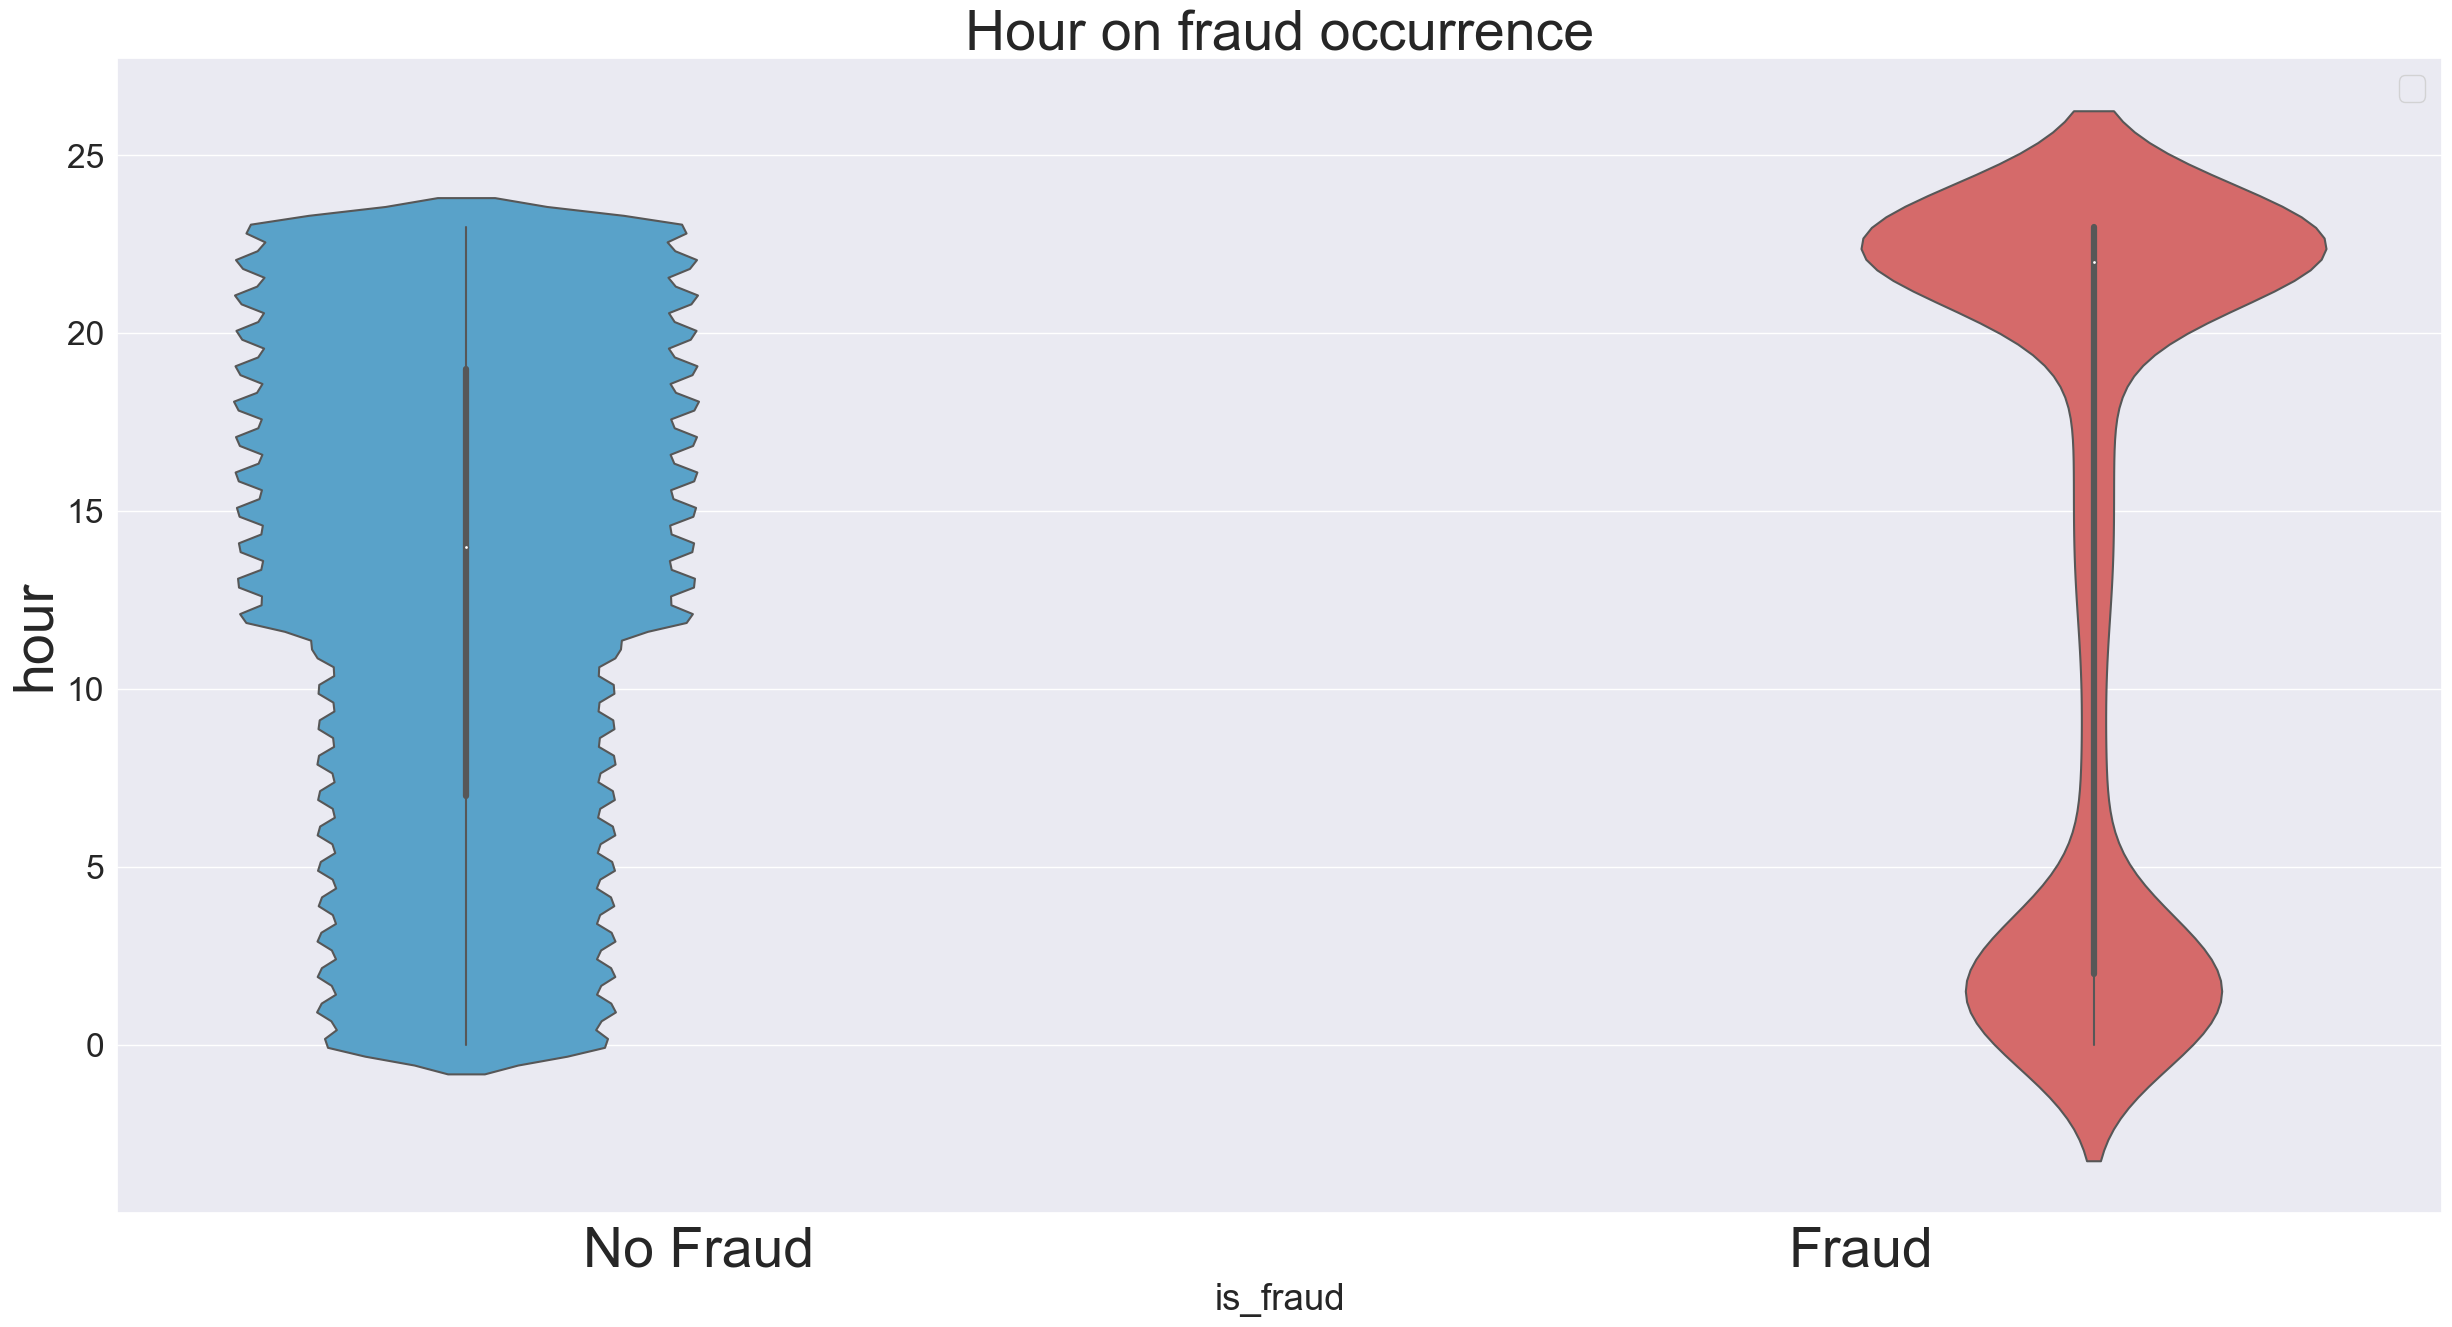

In [10]:
plt.figure(figsize=(30,15))

age_fraud_df = pd.concat([X_train['hour'], y_train], axis=1)
ax = sns.violinplot(data=age_fraud_df, x='is_fraud', y='hour', hue='is_fraud', 
                    palette={0: '#46A7DC', 1: "#E75858"})
utils.set_plot_labels(ax, 
                      title=('Hour on fraud occurrence', 40),  
                      ylab=('hour',40))
ax.set_xticklabels(['No Fraud', 'Fraud'], fontsize=40)
ax.legend([])

plt.show()

### 
### 시간대별 일반거래(위)와 사기거래(아래) 분포

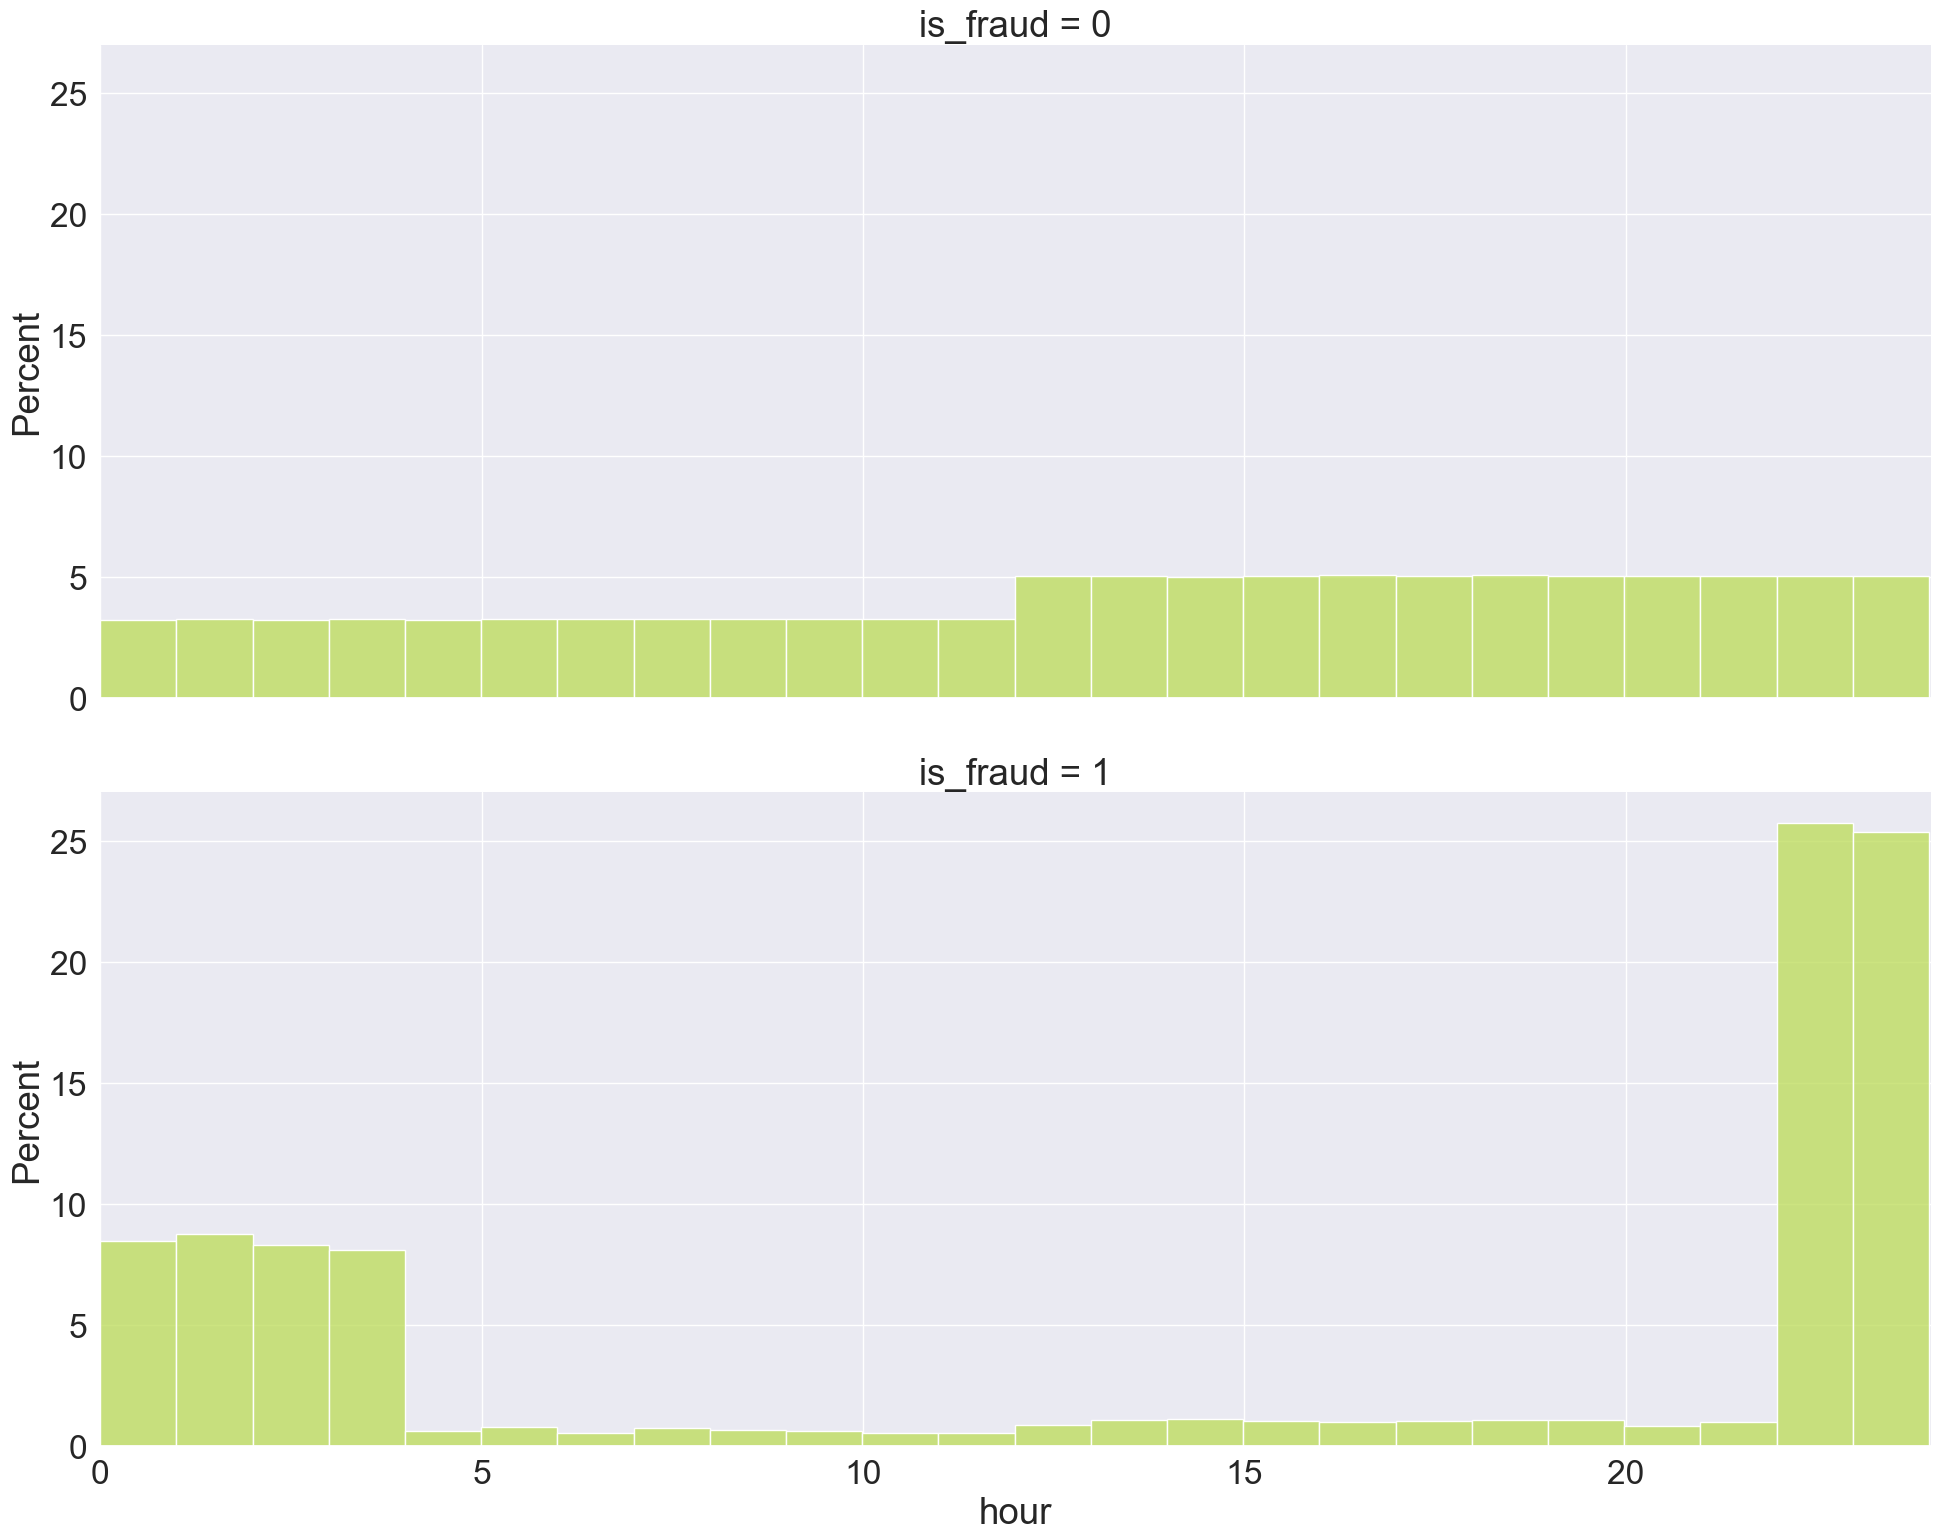

In [11]:
hour_fraud_df = pd.concat([X_train['hour'], y_train], axis=1)
plot = sns.FacetGrid(hour_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(0,24))
plot.map(sns.histplot, 'hour', stat='percent', binwidth=0.999, color='#BCDC56')

### 
### 요일별 일반거래(위)와 사기거래(아래) 분포

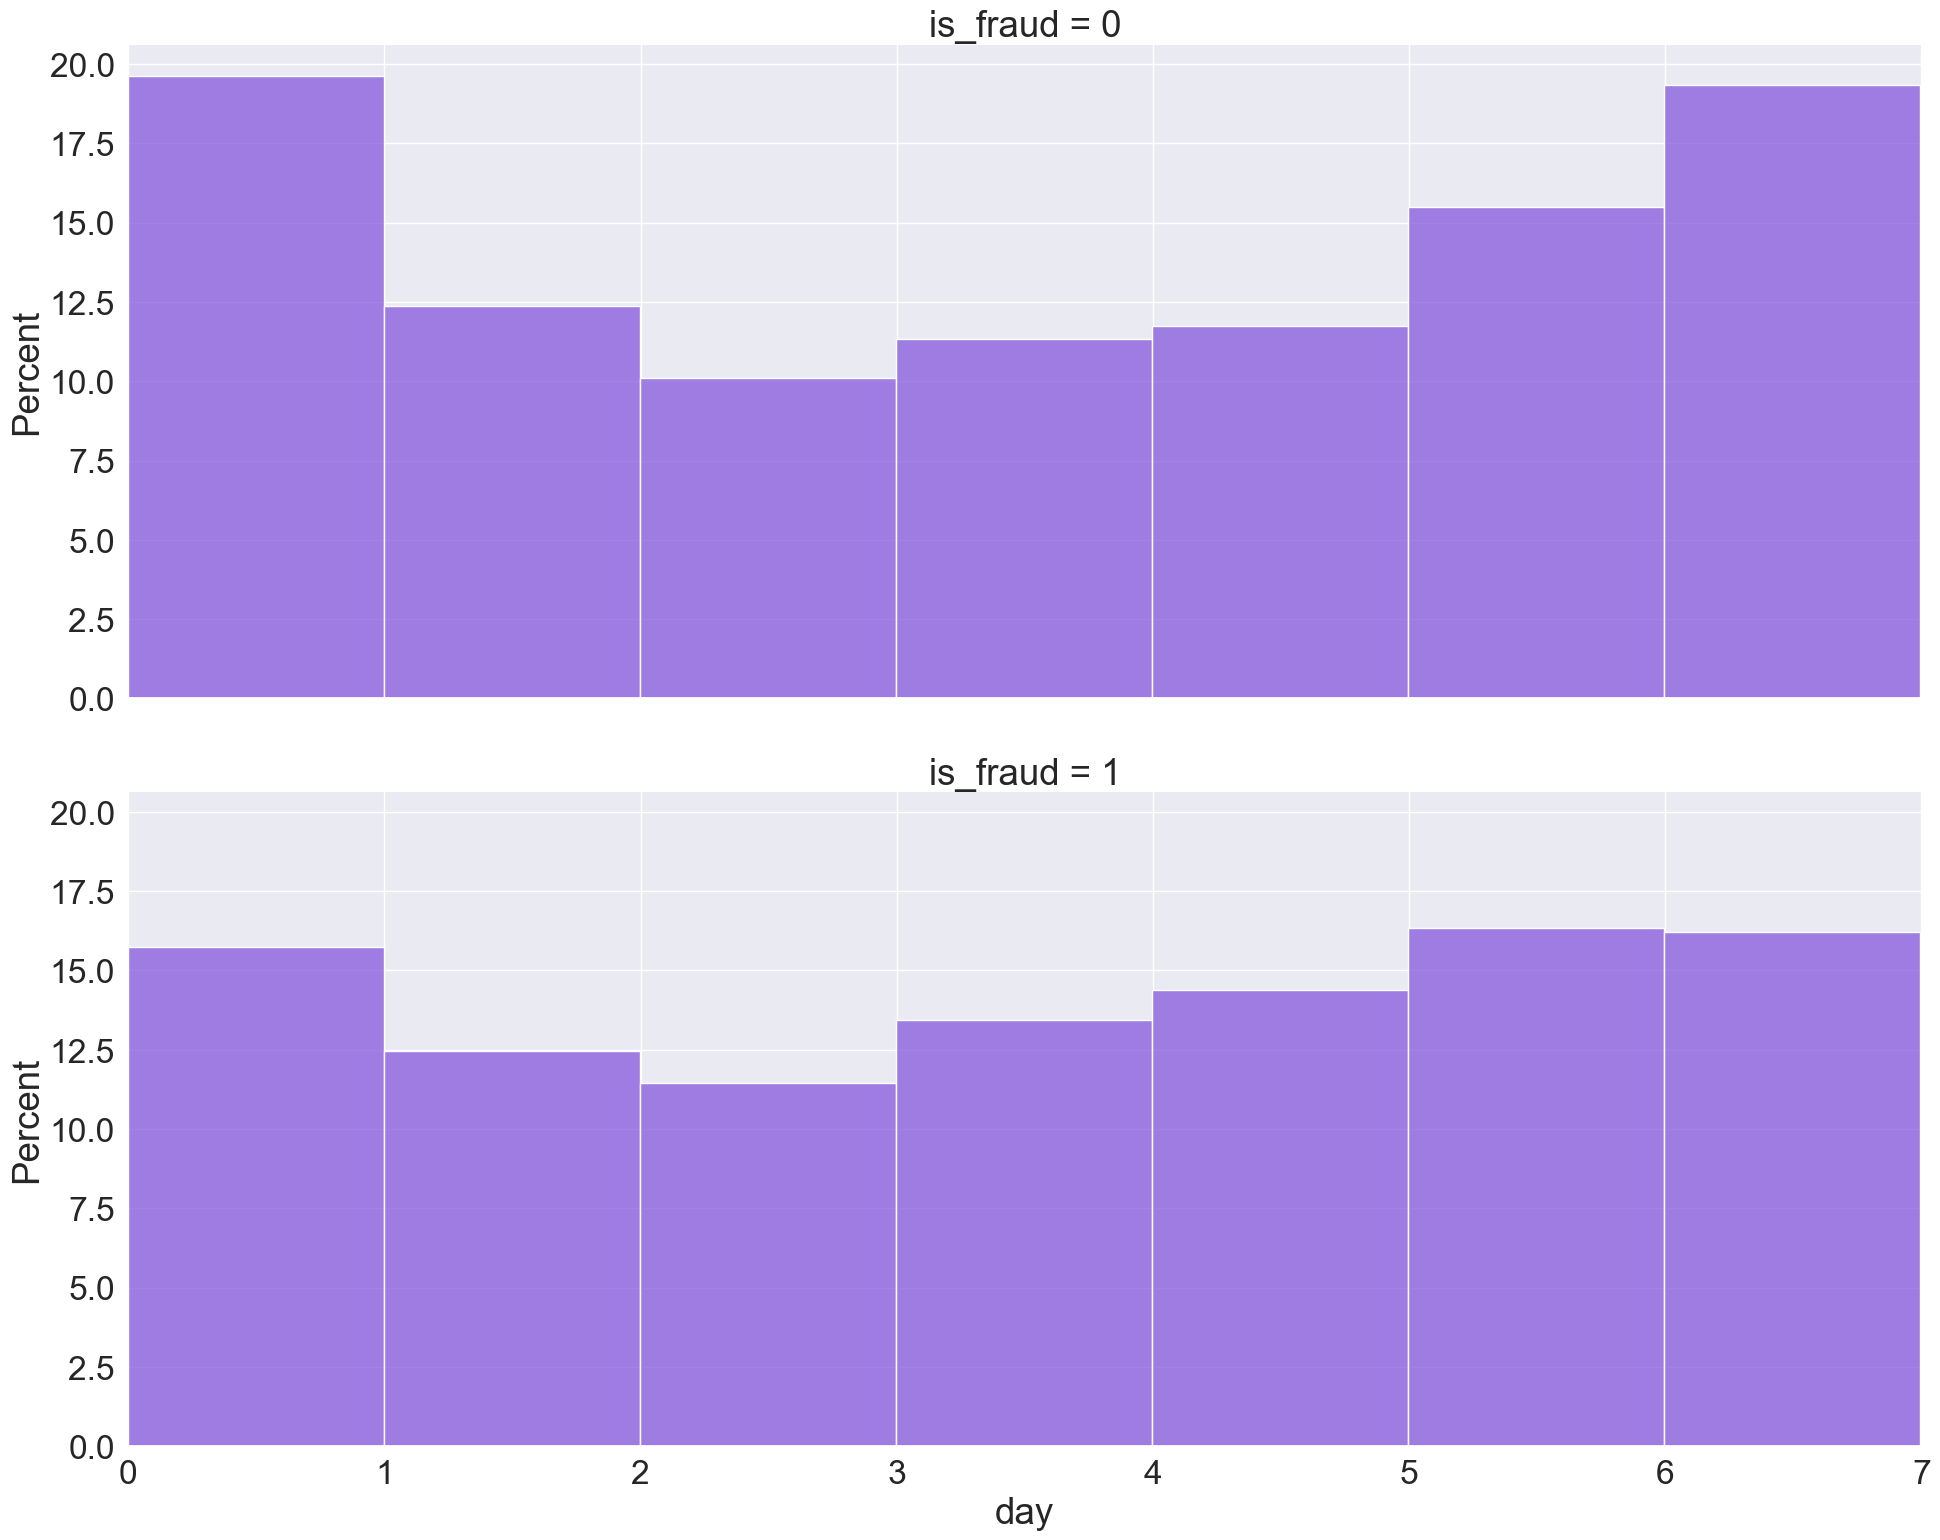

In [12]:
day_fraud_df = pd.concat([X_train['day'], y_train], axis=1)
plot = sns.FacetGrid(day_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(0,7))
plot.map(sns.histplot, 'day', stat='percent', binwidth=0.999, color='#8657DC')

### 
### 월별 일반거래(위)와 사기거래(아래) 분포

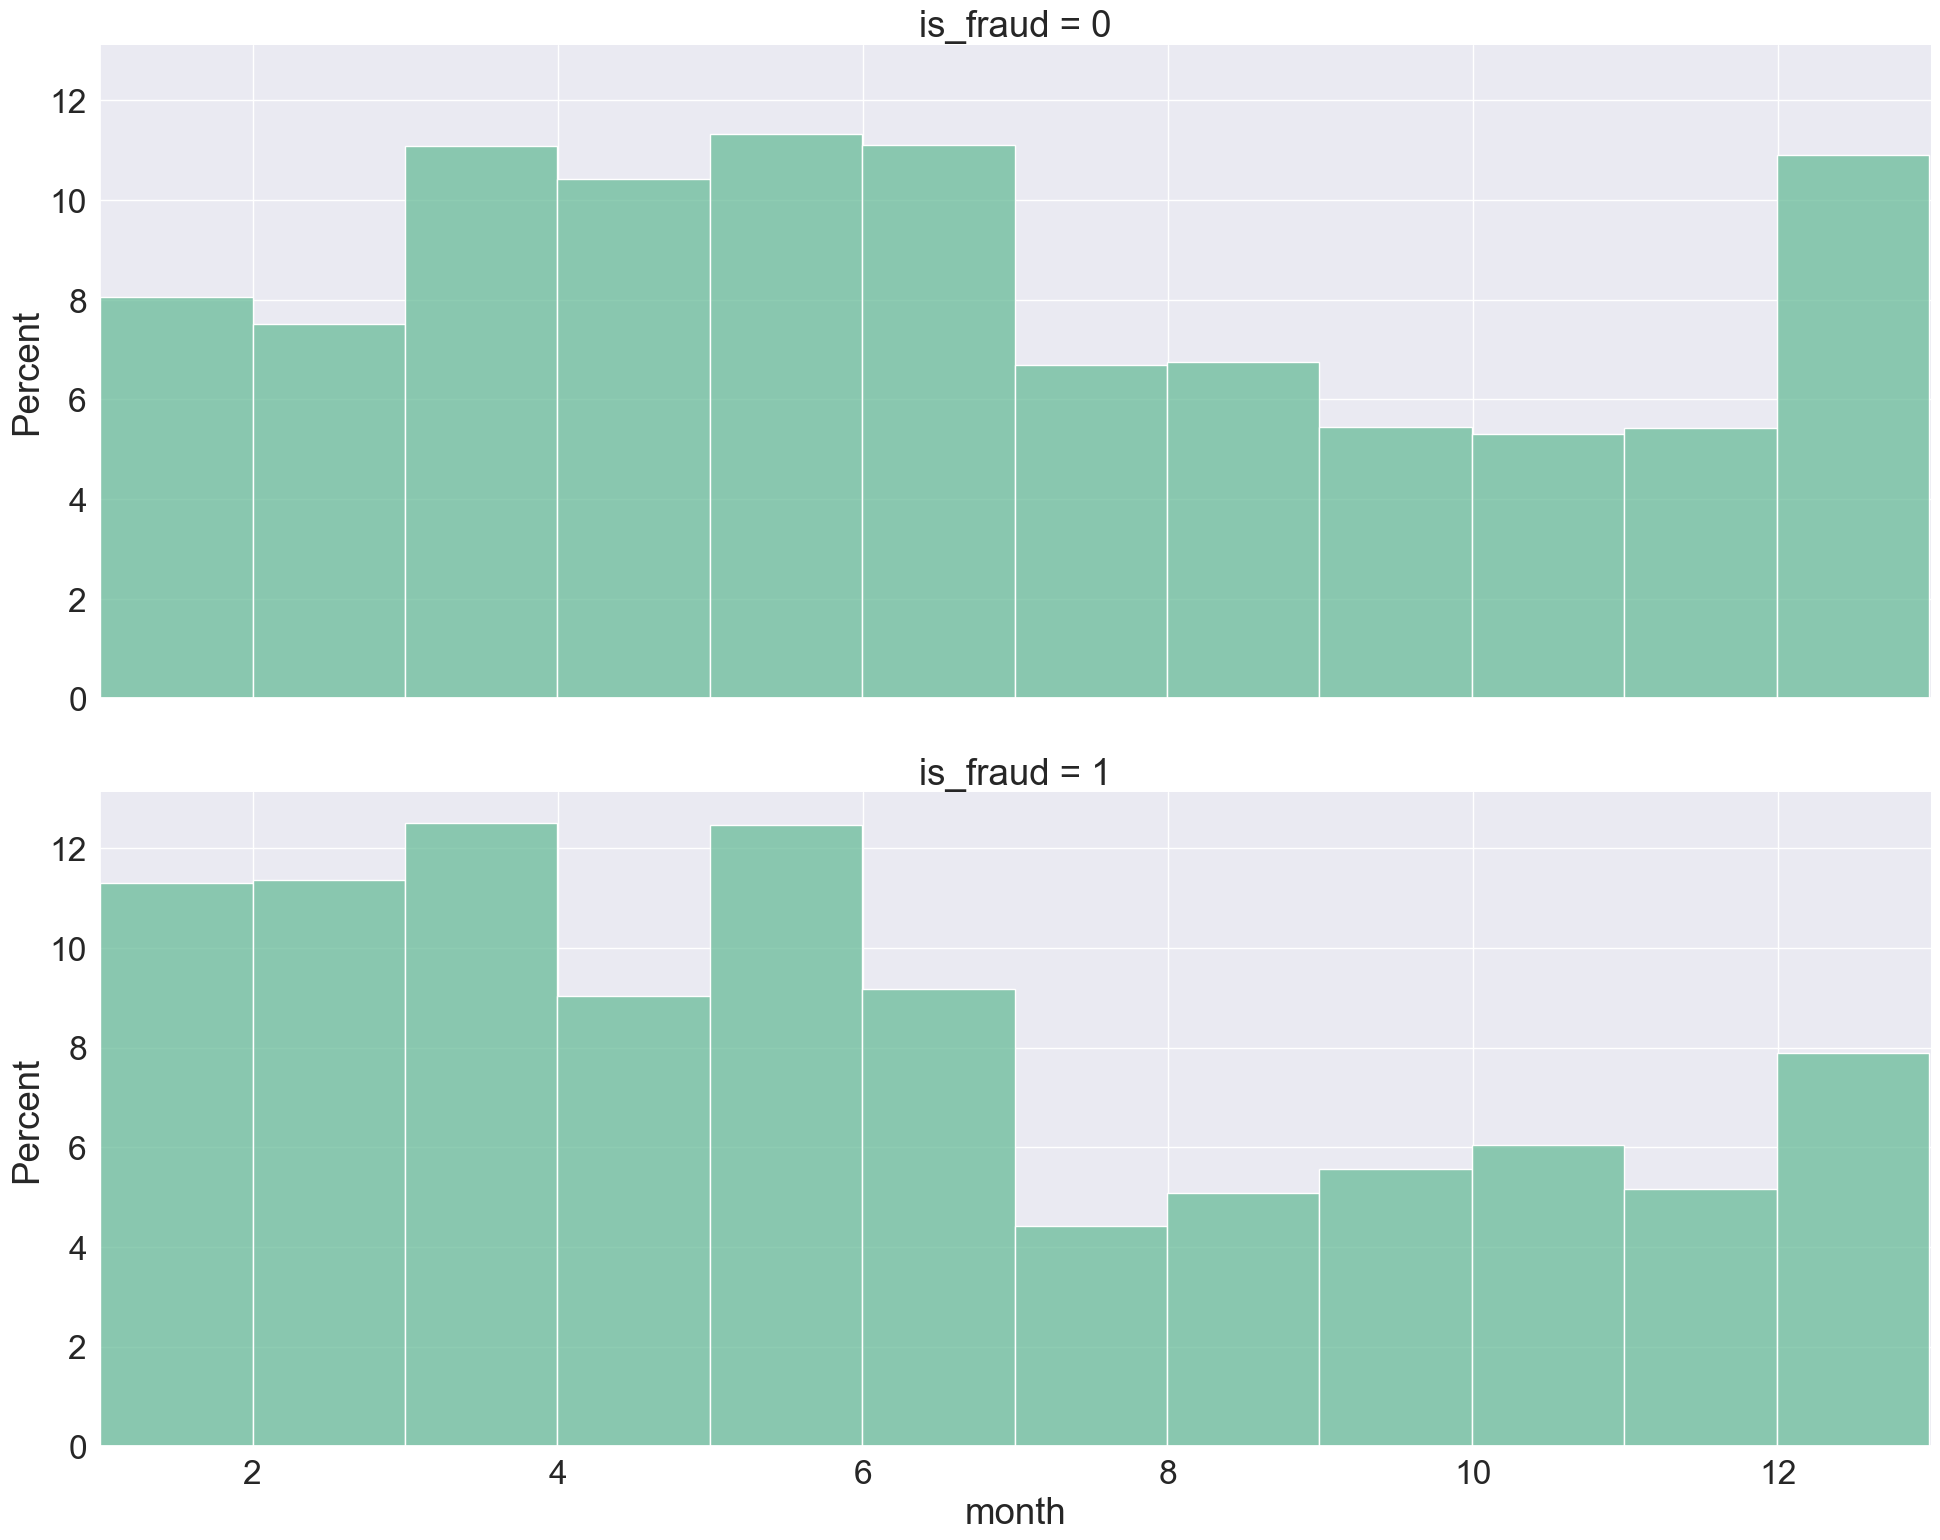

In [13]:
month_fraud_df = pd.concat([X_train['month'], y_train], axis=1)
plot = sns.FacetGrid(month_fraud_df, row='is_fraud', height=8, aspect=2.5, xlim=(1,13))
plot.map(sns.histplot, 'month', stat='percent', binwidth=0.999, color='#69BC99')

### 
### 카드소유주 직업군별 일반거래(위)와 사기거래(아래) 분포

In [14]:
job_cat = datasets.load_job_cat_dataset()

X_train = pd.merge(X_train, job_cat, how = 'left', on = 'job')
X_test = pd.merge(X_test, job_cat, how = 'left', on = 'job')

X_train.loc[0:5, 'job_cat']

0       research/science
1              education
2    military/government
3                    law
4       customer service
5              transport
Name: job_cat, dtype: object

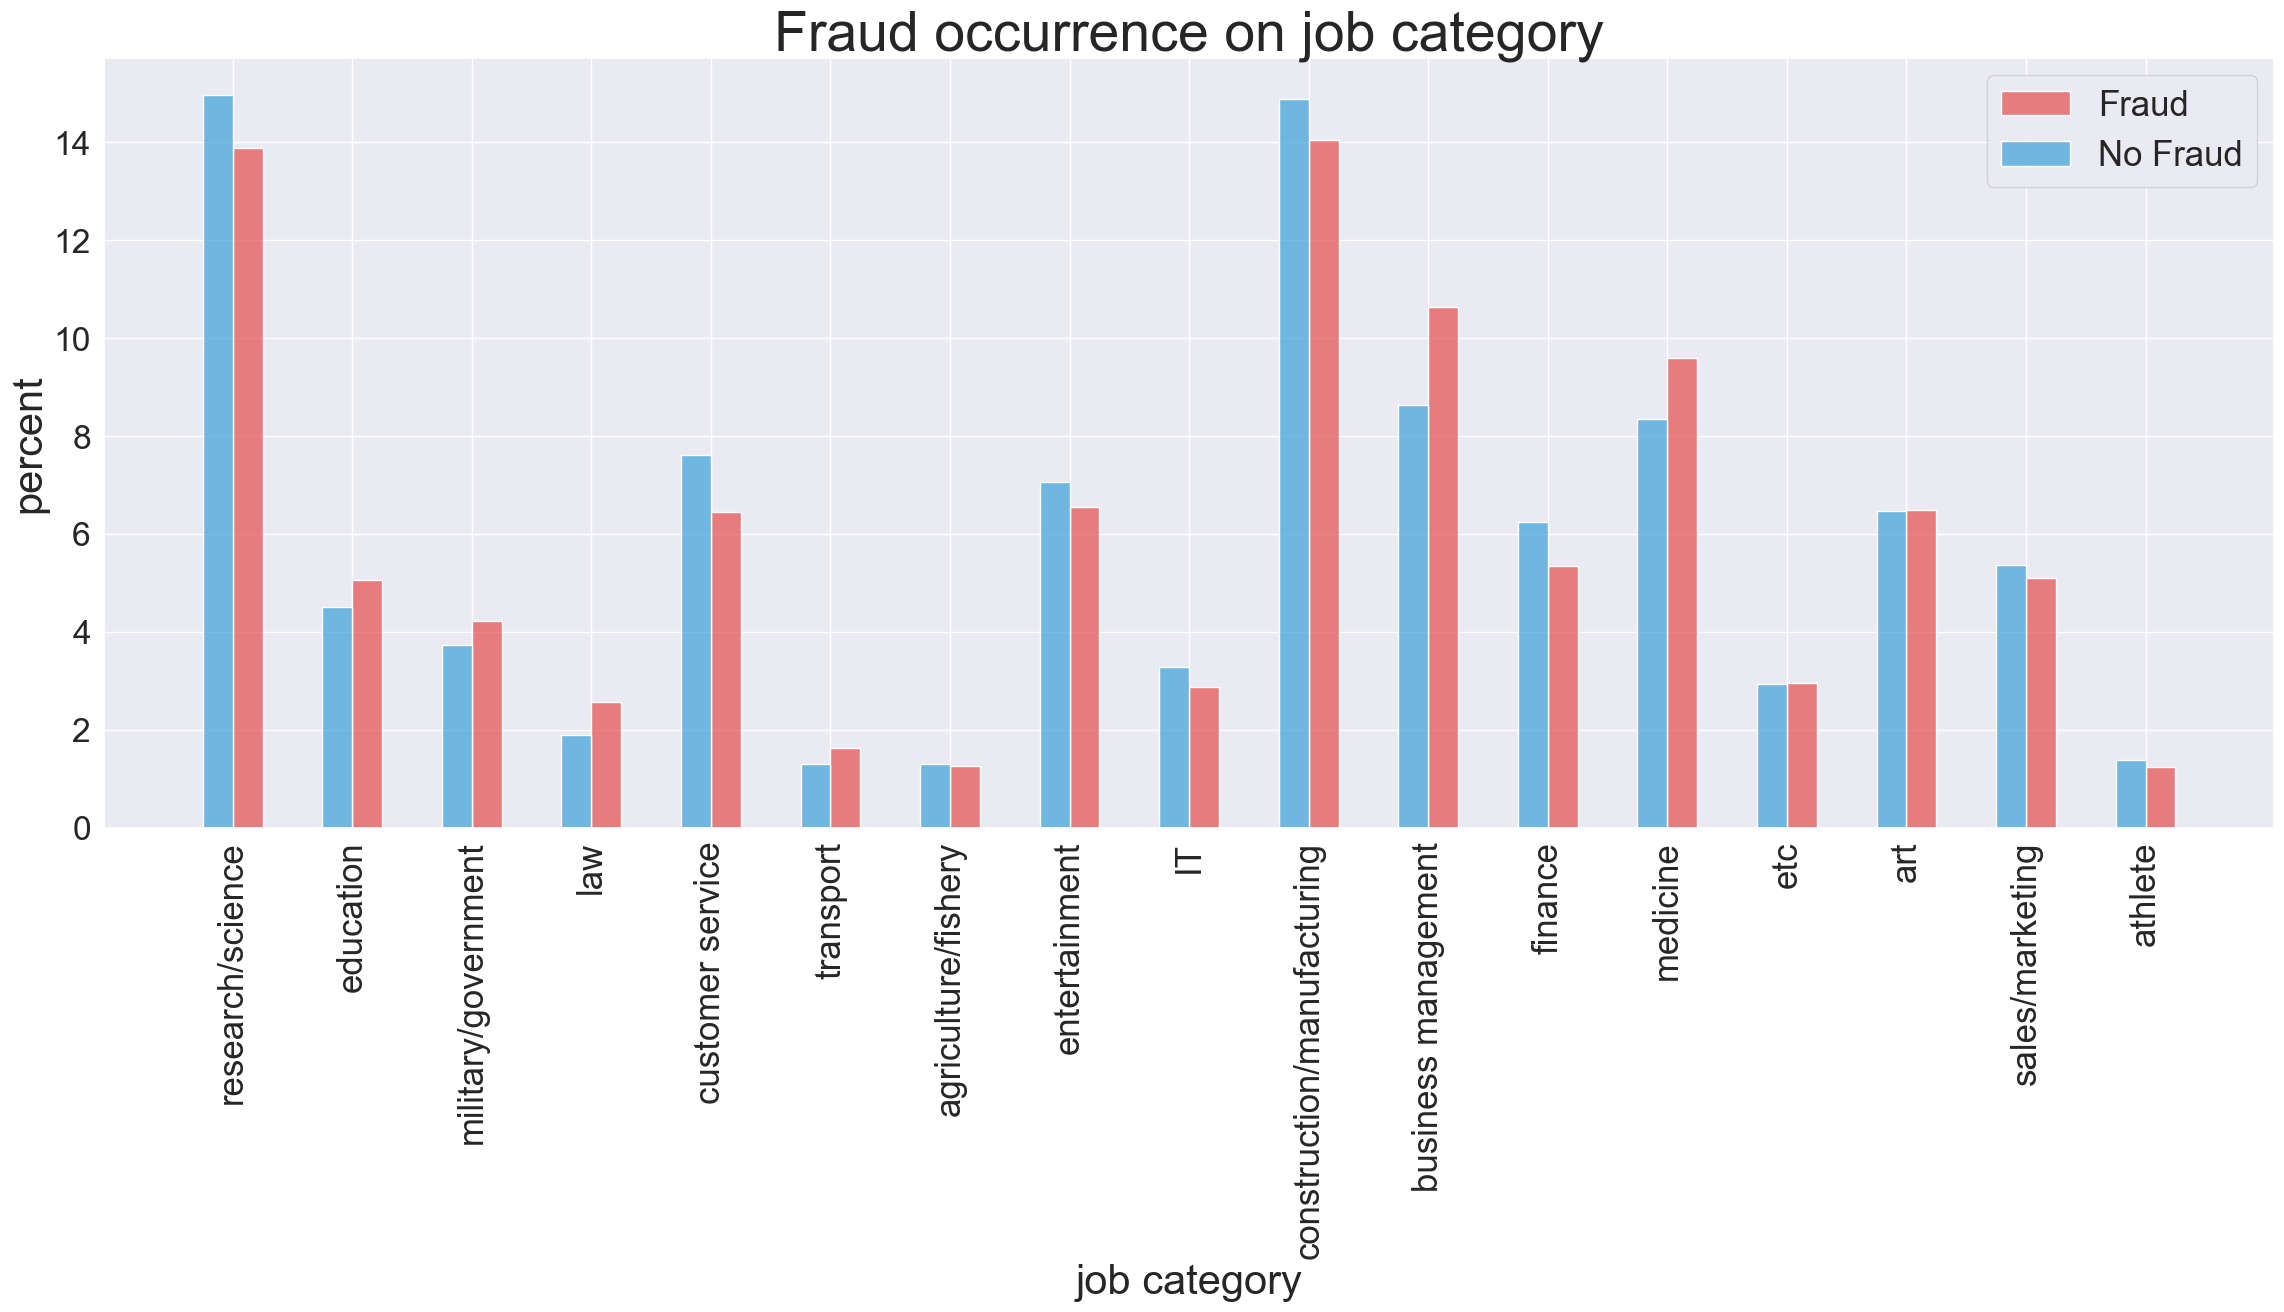

In [15]:
plt.figure(figsize=(28,10))
ax = sns.histplot(data=pd.concat([X_train['job_cat'], y_train], axis=1), 
                  x='job_cat', hue='is_fraud', palette={0: '#46A7DC', 1: "#E75858"},
                  common_norm=False, stat='percent', multiple='dodge', binwidth=1,  shrink= 0.5)
utils.set_plot_labels(ax, 
                      ('Fraud occurrence on job category', 40), 
                      ('job category', 30), 
                      ('percent', 30),
                      (['Fraud', 'No Fraud'], 25))
plt.xticks(size=25, rotation=90)
plt.show()

### 
### 거래 상호군별 일반거래(위)와 사기거래(아래) 분포 분석

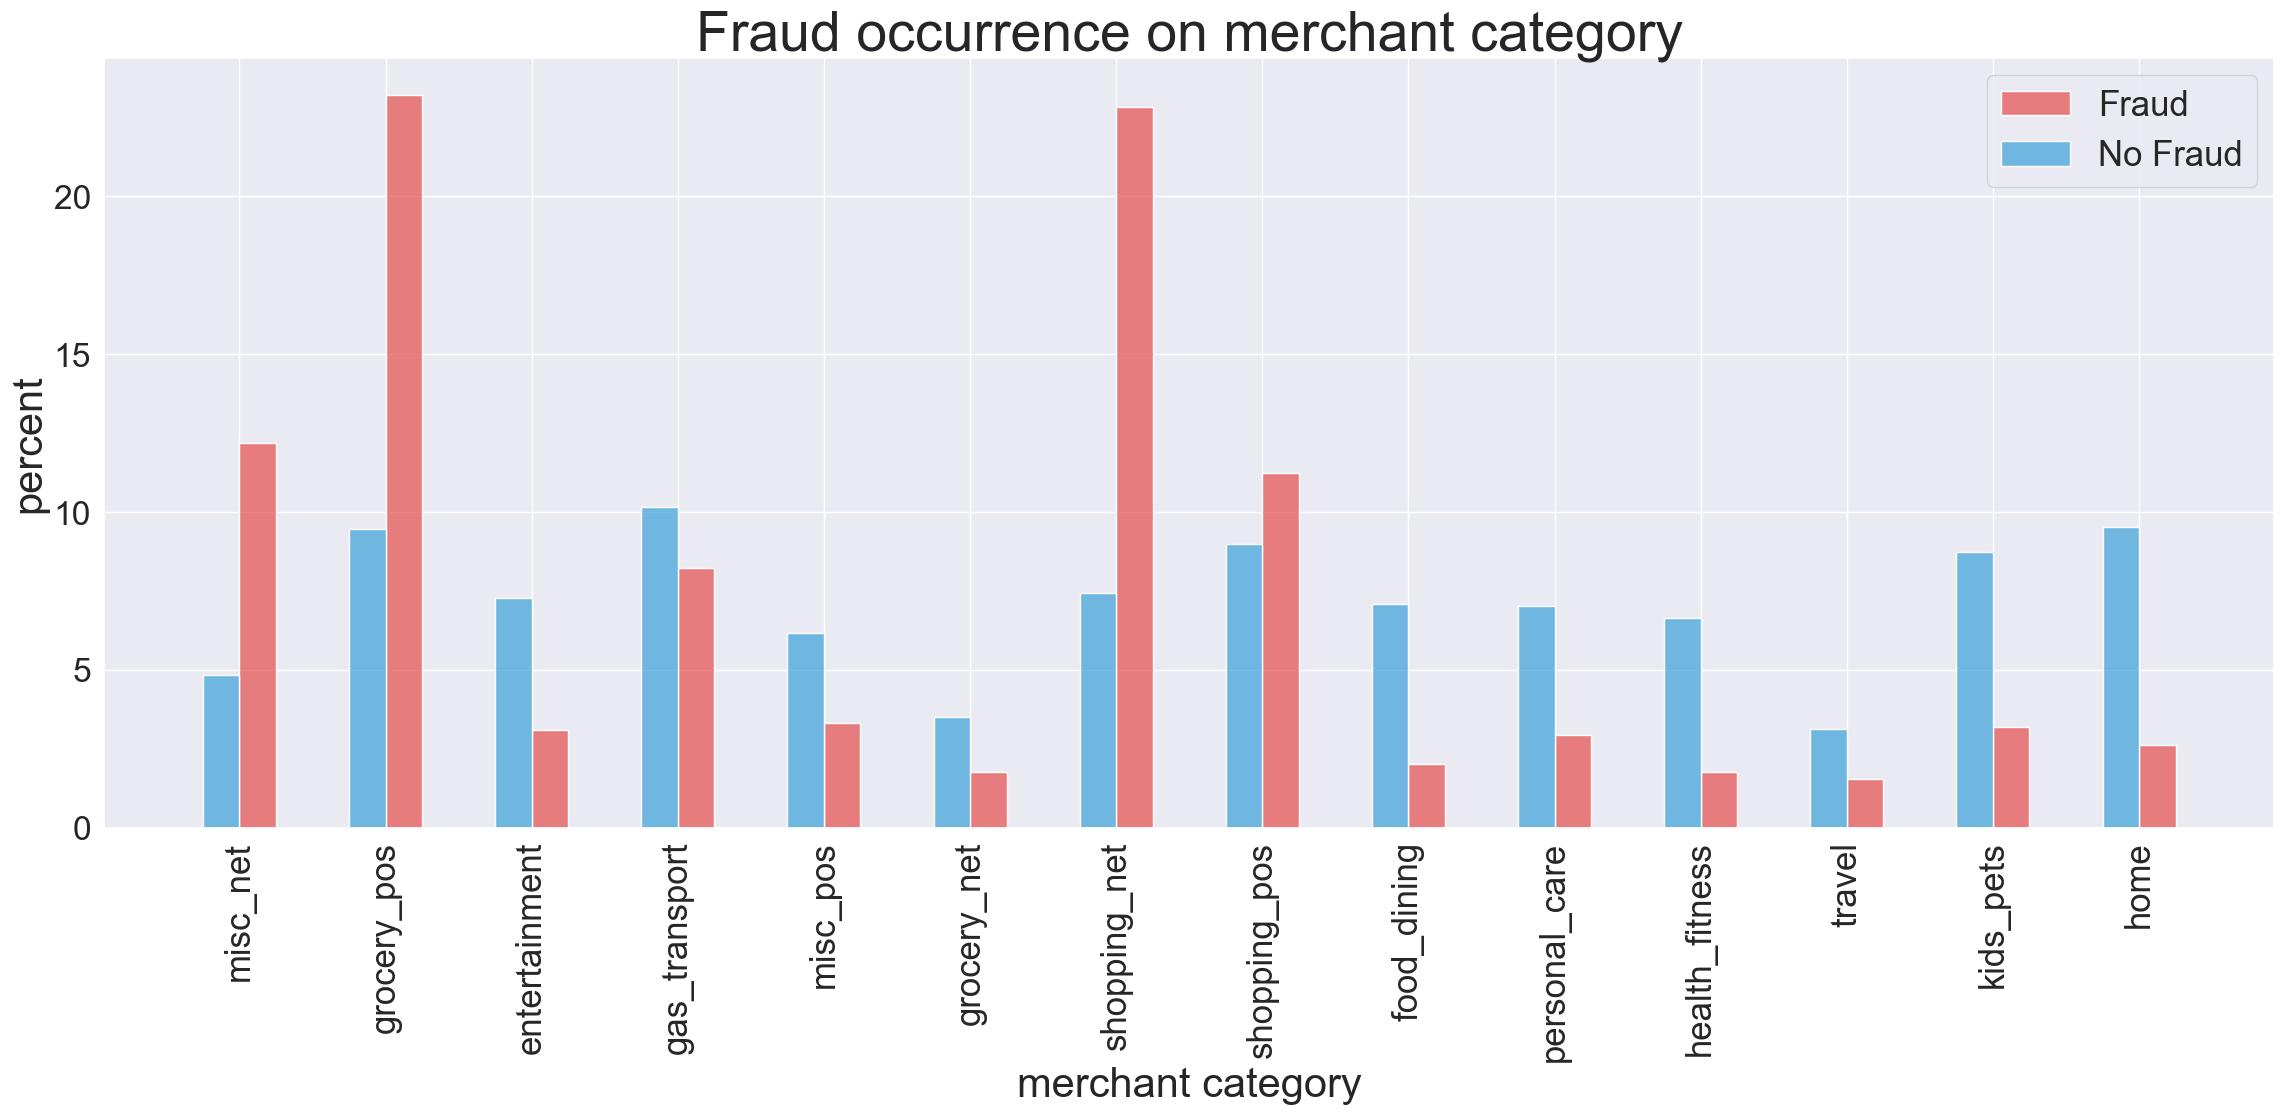

In [16]:
plt.figure(figsize=(28,10))
ax = sns.histplot(data=pd.concat([X_train['merch_cat'], y_train], axis=1), 
                  x='merch_cat', hue='is_fraud', palette={0: '#46A7DC', 1: "#E75858"},
                  common_norm=False, stat='percent', multiple='dodge', binwidth=1,  shrink= 0.5)
utils.set_plot_labels(ax, 
                      ('Fraud occurrence on merchant category', 40),
                      ('merchant category', 30), 
                      ('percent', 30),
                      (['Fraud', 'No Fraud'], 25))
plt.xticks(size=25, rotation=90)
plt.show()

### 
### 공간 데이터 분석

In [17]:
overall_df = pd.concat([X_train, y_train], axis=1)
uniq_fr_cc_num = overall_df.loc[overall_df['is_fraud']==1,:]['cc_num'].unique()

In [18]:
# data frame with a card number of which card was used for fraud at least once
df_w_fraud_card = overall_df.loc[overall_df['cc_num'].isin(uniq_fr_cc_num), :]
# data frame without a card number of which card was used for fraud at least once
df_wo_fraud_card = overall_df.loc[~overall_df['cc_num'].isin(uniq_fr_cc_num), :]

In [19]:
smpld_w_fraud_card = df_w_fraud_card.sample(n=3000, replace=False, random_state=121)
smpld_w_fraud_card.reset_index(inplace=True, drop=True)

smpld_wo_fraud_card = df_wo_fraud_card.sample(n=3000, replace=False, random_state=121)
smpld_wo_fraud_card.reset_index(inplace=True, drop=True)

In [20]:
fraud_map = utils.get_map_with_markers(smpld_w_fraud_card, 'merch_lat', 'merch_long')
no_fraud_map = utils.get_map_with_markers(smpld_wo_fraud_card, 'merch_lat', 'merch_long')

In [21]:
fraud_map

In [22]:
no_fraud_map

<hr>

# 
# 3. 예측 모델을 위한 Feature 선택

In [ ]:
# 원핫 인코딩
X_train = utils.get_new_df_with_onehot_encoding(X_train, 'merch_cat', True)
X_test = utils.get_new_df_with_onehot_encoding(X_test, 'merch_cat', False)

In [ ]:
X_train.info()

# 
# 4. 데이터 불균형 문제 해결

<hr>

# 
# 5. 모델 생성 및 분류 예측

<hr>

# 
# 
# 
# 
# 6. 결과